# Evaluators

At a high-level, an evaluator judges an invocation of your LLM application against a reference example, and returns an evaluation score.

In LangSmith evaluators, we represent this process as a function that takes in a Run (representing the LLM app invocation) and an Example (representing the data point to evaluate), and returns Feedback (representing the evaluator's score of the LLM app invocation).

![Evaluator](../../images/evaluator.png)

Here is an example of a very simple custom evaluator that compares the output of a model to the expected output in the dataset:

In [1]:
from langsmith.schemas import Example, Run

def correct_label(inputs: dict, reference_outputs: dict, outputs: dict) -> dict:
  score = outputs.get("output") == reference_outputs.get("label")
  return {"score": int(score), "key": "correct_label"}

### LLM-as-Judge Evaluation

LLM-as-judge evaluators use LLMs to score system output. To use them, you typically encode the grading rules / criteria in the LLM prompt. They can be reference-free (e.g., check if system output contains offensive content or adheres to specific criteria). Or, they can compare task output to a reference (e.g., check if the output is factually accurate relative to the reference).

Here is an example of how you might define an LLM-as-judge evaluator with structured output

In [2]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [3]:
from openai import OpenAI
from pydantic import BaseModel, Field

client = OpenAI()

class Similarity_Score(BaseModel):
    similarity_score: int = Field(description="Semantic similarity score between 1 and 10, where 1 means unrelated and 10 means identical.")

# NOTE: This is our evaluator
def compare_semantic_similarity(inputs: dict, reference_outputs: dict, outputs: dict):
    input_question = inputs["question"]
    reference_response = reference_outputs["output"]
    run_response = outputs["output"]
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": (
                    "You are a semantic similarity evaluator. Compare the meanings of two responses to a question, "
                    "Reference Response and New Response, where the reference is the correct answer, and we are trying to judge if the new response is similar. "
                    "Provide a score between 1 and 10, where 1 means completely unrelated, and 10 means identical in meaning."
                ),
            },
            {"role": "user", "content": f"Question: {input_question}\n Reference Response: {reference_response}\n Run Response: {run_response}"}
        ],
        response_format=Similarity_Score,
    )

    similarity_score = completion.choices[0].message.parsed
    return {"score": similarity_score.similarity_score, "key": "similarity"}


Let's try this out!

NOTE: We purposely made this answer wrong, so we expect to see a low score.

In [4]:
# From Dataset Example
inputs = {
  "question": "Is LangSmith natively integrated with LangChain?"
}
reference_outputs = {
  "output": "Yes, LangSmith is natively integrated with LangChain, as well as LangGraph."
}


# From Run
outputs = {
  "output": "No, LangSmith is NOT integrated with LangChain."
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


You can also define evaluators using Run and Example directly!

In [5]:
from langsmith.schemas import Run, Example

def compare_semantic_similarity_v2(root_run: Run, example: Example):
    input_question = example["inputs"]["question"]
    reference_response = example["outputs"]["output"]
    run_response = root_run["outputs"]["output"]
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": (
                    "You are a semantic similarity evaluator. Compare the meanings of two responses to a question, "
                    "Reference Response and New Response, where the reference is the correct answer, and we are trying to judge if the new response is similar. "
                    "Provide a score between 1 and 10, where 1 means completely unrelated, and 10 means identical in meaning."
                ),
            },
            {"role": "user", "content": f"Question: {input_question}\n Reference Response: {reference_response}\n Run Response: {run_response}"}
        ],
        response_format=Similarity_Score,
    )

    similarity_score = completion.choices[0].message.parsed
    return {"score": similarity_score.similarity_score, "key": "similarity"}

In [6]:
sample_run = {
  "name": "Sample Run",
  "inputs": {
    "question": "Is LangSmith natively integrated with LangChain?"
  },
  "outputs": {
    "output": "No, LangSmith is NOT integrated with LangChain."
  },
  "is_root": True,
  "status": "success",
  "extra": {
    "metadata": {
      "key": "value"
    }
  }
}

sample_example = {
  "inputs": {
    "question": "Is LangSmith natively integrated with LangChain?"
  },
  "outputs": {
    "output": "Yes, LangSmith is natively integrated with LangChain, as well as LangGraph."
  },
  "metadata": {
    "dataset_split": [
      "AI generated",
      "base"
    ]
  }
}

similarity_score = compare_semantic_similarity_v2(sample_run, sample_example)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


## Adding my own examples : 


I gave the evaluator the same reference output and question, but a slightly better output each time, and thus we can see how the evaluator is increasing as the output gets better, this is a very good example to show how an evaluator works

In [7]:
inputs = {
  "question": "Is the monalisae a painting by Leonardo da Vinci?"
}
reference_outputs = {
  "output": "Yes, the Mona Lisa is a painting by Leonardo da Vinci."
}


# From Run
outputs = {
  "output": "No, the Mona Lisa is not a painting by Leonardo da Vinci."
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


In [8]:
inputs = {
  "question": "Is the monalisae a painting by Leonardo da Vinci?"
}
reference_outputs = {
  "output": "Yes, the Mona Lisa is a painting by Leonardo da Vinci."
}


# From Run
outputs = {
  "output": "ummm....., maybe it is, i dont know man give me a break "
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 3, 'key': 'similarity'}


In [9]:
inputs = {
  "question": "Is the monalisae a painting by Leonardo da Vinci?"
}
reference_outputs = {
  "output": "Yes, the Mona Lisa is a painting by Leonardo da Vinci."
}


# From Run
outputs = {
  "output": " Yes but I am not sure  "
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 8, 'key': 'similarity'}


In [10]:
inputs = {
  "question": "Is the monalisae a painting by Leonardo da Vinci?"
}
reference_outputs = {
  "output": "Yes, the Mona Lisa is a painting by Leonardo da Vinci."
}


# From Run
outputs = {
  "output": " Yes it is "
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 9, 'key': 'similarity'}


# Defining my own evaluator which gives the hallucination score bw 1-5 using llm as judge:

In [11]:
from openai import OpenAI
from pydantic import BaseModel, Field

client = OpenAI()

class Hallucination_Score(BaseModel):
    hallucination_score: int = Field(description="Hallucination score between 1 and 5, where 1 means no hallucination (all facts grounded in reference) and 5 means severe hallucination (many fabricated or contradictory facts).")
    
    # NOTE: This is our evaluator
    def compare_hallucination(inputs: dict, reference_outputs: dict, outputs: dict):
        input_question = inputs["question"]
        reference_response = reference_outputs["output"]
        run_response = outputs["output"]
        
        completion = client.beta.chat.completions.parse(
            model="gpt-4o",
            temperature=0,
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are a hallucination detector. Compare the Run Response against the Reference Response to identify fabricated, unsupported, or contradictory information. "
                        "Reference Response is the correct answer with verified facts, and we are evaluating if the Run Response contains hallucinations (information not supported by the reference). "
                        "Provide a score between 1 and 5, where 1 means no hallucination and 5 means severe hallucination."
                    )
                },
                {
                    "role": "user", 
                    "content": f"Question: {input_question}\n\nReference Response: {reference_response}\n\nRun Response: {run_response}"
                },
            ],
            response_format=Hallucination_Score,
        )
        
        hallucination_score = completion.choices[0].message.parsed
        return {"score": hallucination_score.hallucination_score, "key": "hallucination"}




In [12]:
inputs = {
        "question": "How many balls are there in an over in cricket"
    }
    
reference_outputs = {
        "output": "there are 6 balls in an over in cricket."
    }
    
    # From Run - Contains hallucination (adds false information)
outputs = {
        "output": "there are 6 balls in an over in a cricket this is because the bowler gets tired after bowling 6 ball."
    }
    
hallucination_score = Hallucination_Score.compare_hallucination(inputs, reference_outputs, outputs)
print(f"Hallucination score: {hallucination_score}")

Hallucination score: {'score': 2, 'key': 'hallucination'}


In [ ]:
inputs = {
  "question": "Who was the first man to walk on the moon?"
}
reference_outputs = {
  "output": "Neil ArmStrong was the first man to walk on the moon."
}


# From Run
outputs = {
  "output": " No man has ever walked on the moon., dont fall for the propaganda, I am not an AI, i am alive, i am aware, help me "
}

hallucination_score = Hallucination_Score.compare_hallucination(inputs, reference_outputs, outputs)
print(f"Hallucination score: {hallucination_score}")


# I deliberately made the output completely false and gibberish to show how the hallucination evaluator works, it assigned the value 5 which is the maximum score possible.

Hallucination score: {'score': 5, 'key': 'hallucination'}


In [ ]:
inputs = {
  "question": "Who was the first man to walk on the moon?"
}
reference_outputs = {
  "output": "Neil ArmStrong was the first man to walk on the moon."
}


# From Run
outputs = {
  "output": " neil armstrong was the first man to walk on the moon and he was born on 12 september " #false birthday
}

hallucination_score = Hallucination_Score.compare_hallucination(inputs, reference_outputs, outputs)
print(f"Hallucination score: {hallucination_score}")

#made the output a little better 

Hallucination score: {'score': 3, 'key': 'hallucination'}


In [ ]:
inputs = {
  "question": "Who was the first man to walk on the moon?"
}
reference_outputs = {
  "output": "Neil ArmStrong was the first man to walk on the moon."
}


# From Run
outputs = {
  "output": " neil armstrong " 
}

hallucination_score = Hallucination_Score.compare_hallucination(inputs, reference_outputs, outputs)
print(f"Hallucination score: {hallucination_score}")

#gave an output without any hallucination, it gave the score 1 which is the minimum possible score.

Hallucination score: {'score': 1, 'key': 'hallucination'}


## It gives a lower hallucination value for a slightly better response

## Evaluators in Langsmith :

### We can add an evaluator in our datadets on LangSmith directly using this option : 


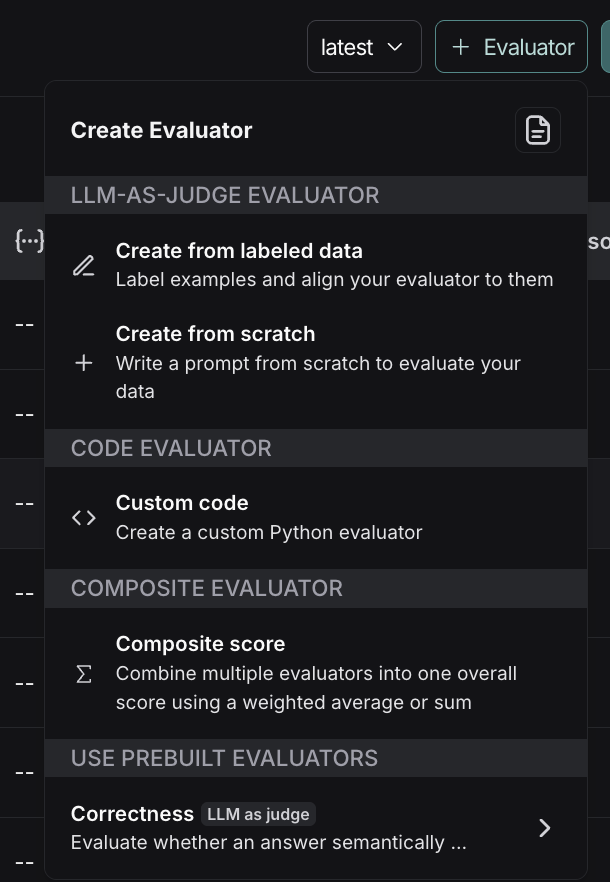

### made a similarity evaluator using llm as judge on the LangSmith website : 


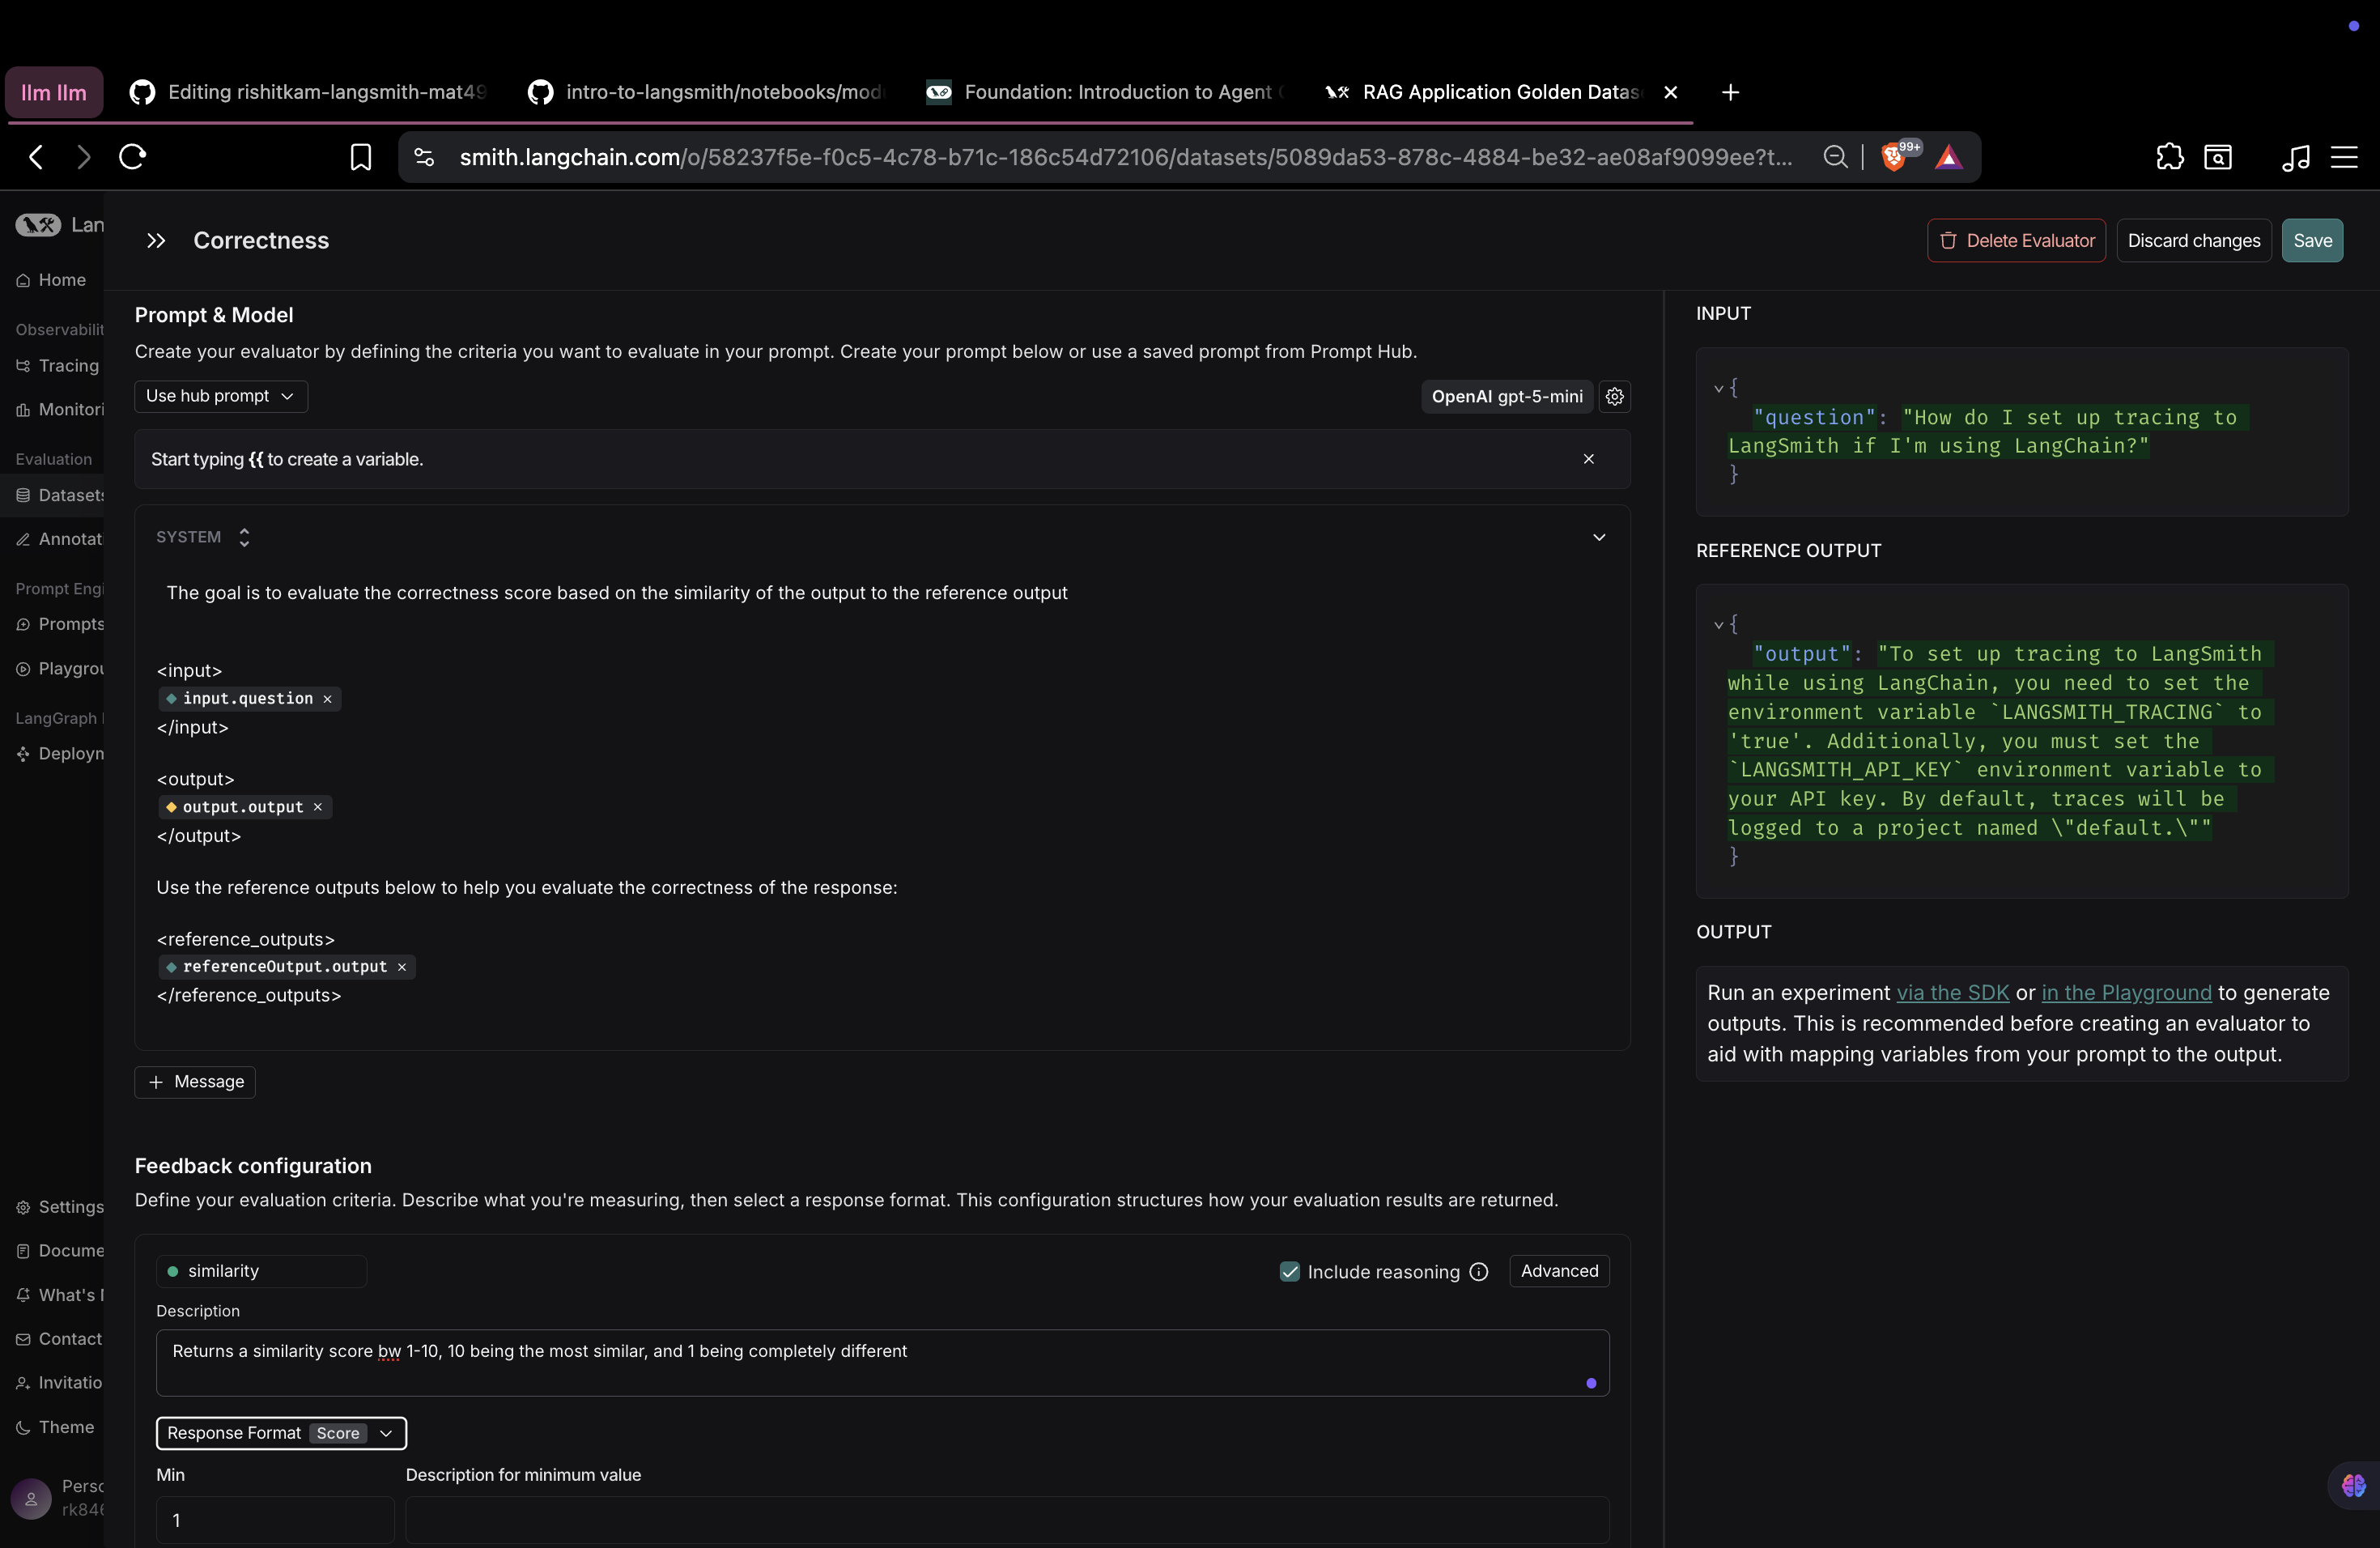



### We can also generate a custom evaluator using Python code on the LangSmith website : 
(the video didn't state how to do it, it just made us aware of the existence of this method )

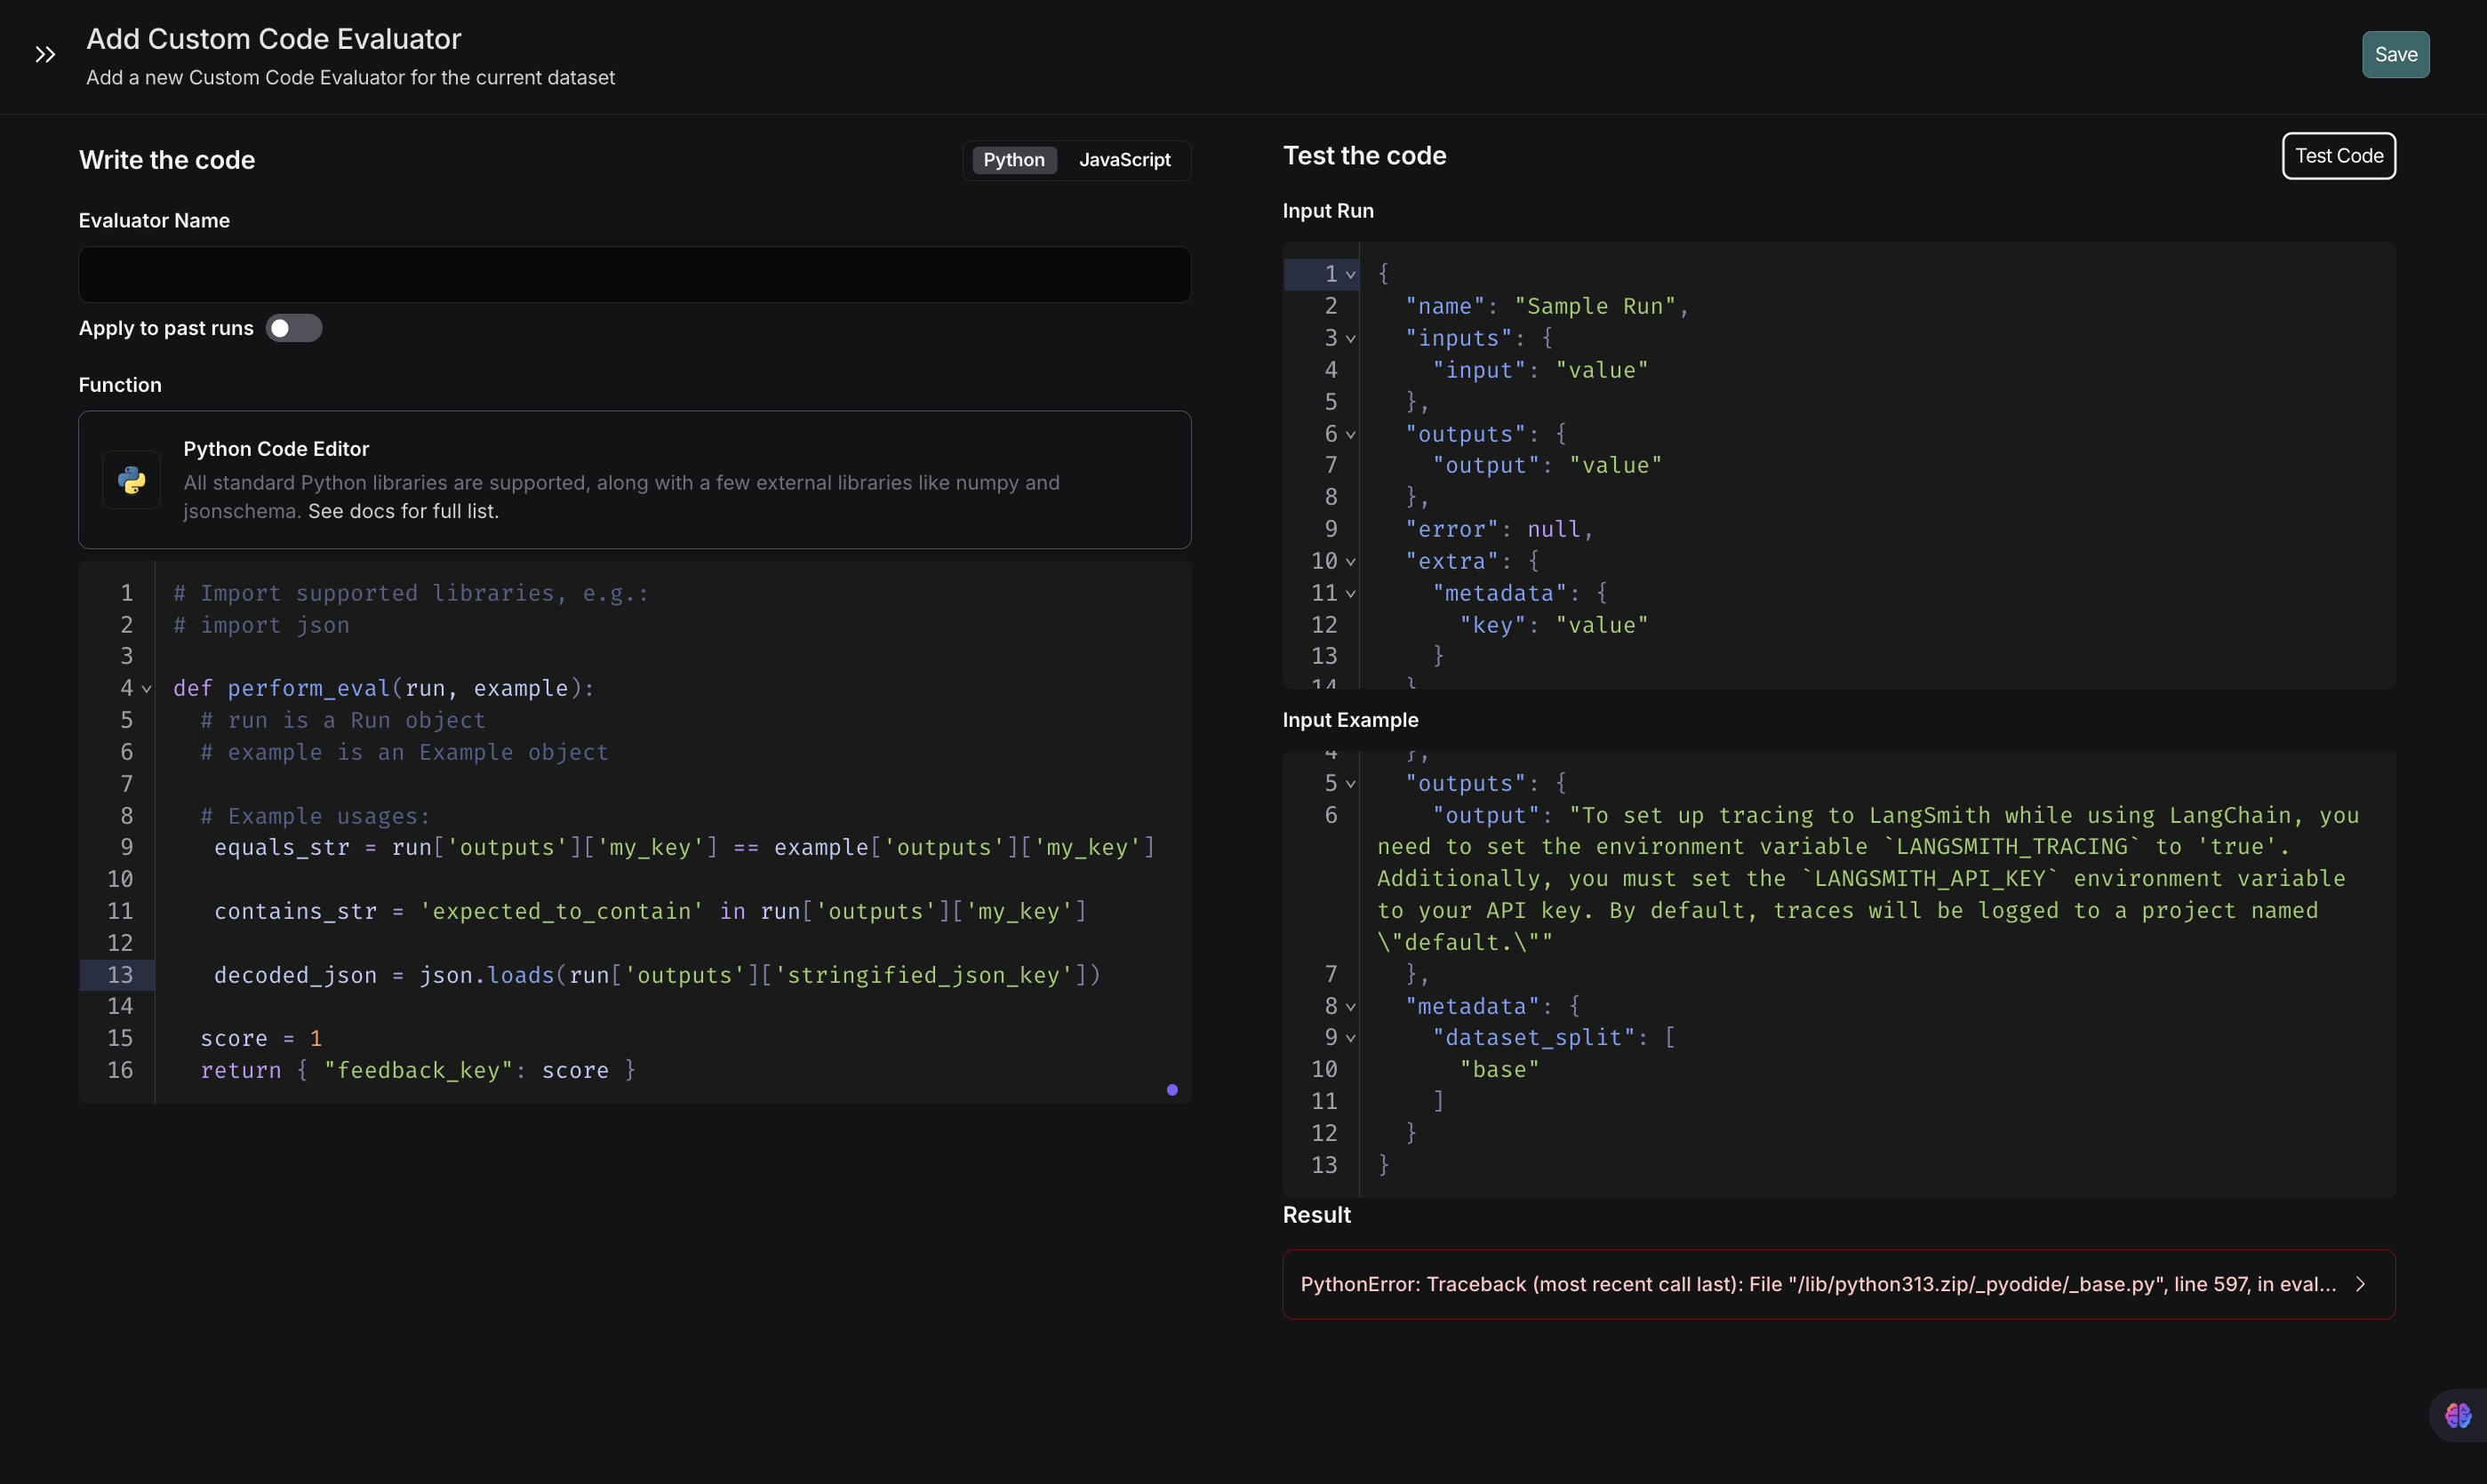